In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, SelectFromModel

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

In [2]:
df = pd.read_csv("../data/raw/numerical.csv")

In [3]:
df.head()

,date,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,...,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,percentAumCovered,sustainRank,responsible,sustainScore
0,2024-12-31,0.0,0.237,1.690800e+09,NaN,NaN,1.150600e+09,175400000.0,4.144100e+09,1.690800e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,2023-12-31,0.0,0.241,1.710100e+09,NaN,NaN,1.155000e+09,177300000.0,3.992200e+09,1.710100e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,2022-12-31,0.0,0.245,1.630900e+09,NaN,NaN,1.086900e+09,176600000.0,3.764800e+09,1.630900e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,2021-12-31,0.0,0.234,1.388200e+09,NaN,NaN,9.250000e+08,170700000.0,3.233700e+09,1.388200e+09,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,2020-12-31,NaN,NaN,NaN,1400000.0,1400000.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [4]:
front_columns = ['symbol', 'date', 'companySize', 'region', 'totalEsg', 'marketCap']
to_drop = ['Ticker', 'shortName', 'longName', 'cumulativeMarketCapPercentage', 'ratingMonth', 'ratingYear'] # duplicate info & unnecessary columns

all_columns = df.columns.tolist()
new_column_order = front_columns + [col for col in all_columns if col not in front_columns and col not in to_drop] 

# Reindex the DataFrame with the new column order
df = df[new_column_order]

In [5]:
df.head()

,symbol,date,companySize,region,totalEsg,marketCap,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,...,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,percentAumCovered,sustainRank,responsible,sustainScore
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,0.237,1.690800e+09,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,0.241,1.710100e+09,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,0.245,1.630900e+09,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,0.234,1.388200e+09,NaN,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,4.367976e+10,NaN,NaN,NaN,1400000.0,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [6]:
df.shape

(4646, 386)

In [7]:
df['symbol'].nunique()

1012

In [8]:
# Create a latest_date feature to align different EOY financial dates
df['latest_date'] = df.groupby('symbol')['date'].transform('max')

In [9]:
df['latest_date'].value_counts()

latest_date
2024-12-31    2603
2024-03-31     925
2023-12-31     444
2024-06-30     180
2024-09-30     156
2025-01-31      74
2024-02-29      58
2024-08-31      44
2024-07-31      34
2024-10-31      33
2024-01-31      28
2024-05-31      25
2024-04-30      15
2023-03-31      11
2022-12-31      11
2024-11-30       5
Name: count, dtype: int64

In [10]:
df['latest_year'] = df['latest_date'].apply(lambda x: x.split('-')[0])

## Data Cleaning

### Assessing Missingness Patterns

In [11]:
df.shape

(4646, 388)

In [12]:
# Drop features with more than 70% missing values, as they offer too little information to be imputed
pct_null = df.isnull().mean()
df = df.drop(columns=pct_null[pct_null > 0.7].index.tolist())
df.shape

(4646, 227)

### Assessing constant features

Features with zero or very low variance provide little information and can be removed.

In [13]:
# Calculate variance for each numerical column
feature_variance = df.var(numeric_only=True)
feature_variance.sort_values(ascending=True).head(10)

maxAge                0.000000e+00
Tax Rate For Calcs    6.051133e-03
highestControversy    1.181631e+00
governanceScore       8.557575e+00
socialScore           1.242530e+01
environmentScore      3.344256e+01
totalEsg              6.903441e+01
peerCount             3.467076e+04
Diluted EPS           1.500915e+07
Basic EPS             1.514600e+07
dtype: float64

In [14]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(df.select_dtypes(include=[np.number]).fillna(0))
constant_feats = df.select_dtypes(include=[np.number]).columns[~vt.get_support()]
constant_feats

Index(['Tax Rate For Calcs', 'maxAge'], dtype='object')

In [15]:
df = df.drop(columns=constant_feats)

In [16]:
df.shape

(4646, 225)

### Missing Value Imputation

Step 1: Company‑level ffill/bfill (and/or rolling)

Step 2: Peer‑group imputation (region + company size + year)

Step 3: Global/statistical imputer (median) for any stragglers

In [17]:
# defining columns that should be imputed
df_sorted = df.sort_values(by=['symbol', 'latest_year'], ascending=True)
meta_numeric = ['date', 'latest_date', 'latest_year', 'totalEsg', 'environmentScore', 'socialScore', 'governanceScore']

cols_to_impute = df_sorted.select_dtypes(include=np.number).columns.tolist()
# remove identifiers/targets if they are numeric and shouldn't be imputed this way
cols_to_impute = [col for col in cols_to_impute if col not in meta_numeric]

In [18]:
# Step 1: company-level historical imputation
df_filled = df_sorted.copy()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].ffill()
df_filled[cols_to_impute] = df_filled.groupby('symbol')[cols_to_impute].bfill()

In [19]:
len(df_filled[cols_to_impute].columns[df_filled[cols_to_impute].isnull().any()].tolist())

161

In [20]:
# Step 2
cols_to_impute_final = [
    col for col in df_filled.select_dtypes(include=np.number).columns.tolist()
    if col not in meta_numeric
    and df_filled[col].isnull().any() # Only consider columns with NaNs remaining
]

In [21]:
df_filled.groupby(['region', 'companySize', 'latest_year']).count().head()

symbol  date  totalEsg  \
region              companySize latest_year                           
east_asia_n_pacific Large-Cap   2022              3     3         3   
                                2023             48    48        48   
                                2024            204   204       204   
                    Mid-Cap     2023            104   104       104   
                                2024            332   332       332   

                                             marketCap  \
region              companySize latest_year              
east_asia_n_pacific Large-Cap   2022                 3   
                                2023                48   
                                2024               204   
                    Mid-Cap     2023               104   
                                2024               332   

                                             Tax Effect Of Unusual Items  \
region              companySize latest_year                                
east_asia_n_pacific Large-Cap   2022                                   3   
                                2023                                  48   
                                2024                                 204   
                    Mid-Cap     2023                                 104   
                                2024                                 332   

                                             Normalized EBITDA  \
region              companySize latest_year                      
east_asia_n_pacific Large-Cap   2022                         3   
                                2023                        40   
                                2024                       158   
                    Mid-Cap     2023                        84   
                                2024                       273   

                                             Total Unusual Items  \
region              companySize latest_year                        
east_asia_n_pacific Large-Cap   2022                           3   
                                2023                          44   
                                2024                         189   
                    Mid-Cap     2023                          92   
                                2024                         252   

                                             Total Unusual Items Excluding Goodwill  \
region              companySize latest_year                                           
east_asia_n_pacific Large-Cap   2022                                              3   
                                2023                                             44   
                                2024                                            189   
                    Mid-Cap     2023                                             92   
                                2024                                            252   

                                             Net Income From Continuing Operation Net Minority Interest  \
region              companySize latest_year                                                               
east_asia_n_pacific Large-Cap   2022                                                         3            
                                2023                                                        48            
                                2024                                                       204            
                    Mid-Cap     2023                                                       104            
                                2024                                                       332            

                                             Reconciled Depreciation  ...  \
region              companySize latest_year                           ...   
east_asia_n_pacific Large-Cap   2022                               3  ...   
                                2023                              48  ...   

In [22]:
for col in cols_to_impute_final:
    # Use transform with median. It aligns results back to the original DataFrame index.
    df_filled[col] = df_filled.groupby(['region', 'companySize', 'latest_year'])[col].transform(lambda x: x.fillna(x.median()))

In [23]:
remaining_nan_counts = df_filled[cols_to_impute_final].isnull().sum()
cols_still_nan = remaining_nan_counts[remaining_nan_counts > 0].index.tolist()

In [24]:
remaining_nan_counts[remaining_nan_counts > 0].sort_values(ascending=True).head(10)

Other Properties                        2
Net Business Purchase And Sale          2
Net Investment Purchase And Sale        2
Goodwill And Other Intangible Assets    3
Operating Cash Flow                     3
Other Non Cash Items                    3
Change In Payable                       3
Change In Working Capital               3
Depreciation And Amortization           3
Other Intangible Assets                 3
dtype: int64

In [25]:
len(remaining_nan_counts[remaining_nan_counts > 20].index.tolist())

64

In [26]:
# Step 3
for col in cols_still_nan:
    global_median_val = df_filled[col].median()
    df_filled[col] = df_filled[col].fillna(global_median_val)

    df_filled[cols_to_impute_final].isnull().sum().sort_values(ascending=True).head(10)

In [27]:
df_filled.sort_index().head()

,symbol,date,companySize,region,totalEsg,marketCap,Tax Effect Of Unusual Items,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,...,gambling,gmo,militaryContract,nuclear,pesticides,palmOil,coal,tobacco,latest_date,latest_year
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.690800e+09,1400000.0,1400000.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.710100e+09,1400000.0,1400000.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.630900e+09,1400000.0,1400000.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.388200e+09,1400000.0,1400000.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.388200e+09,1400000.0,1400000.0,...,False,False,False,False,False,False,False,False,2024-12-31,2024


In [28]:
df = df_filled

In [29]:
df.columns[df.isnull().any()].tolist()

['environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco']

## Feature Engineering

### Feature Creation

Creating different financial ratios

In [30]:
def safe_div(numer, denom):
    """Divide two values, returning NaN where denominator is zero or NaN."""
    return numer.div(denom).replace([np.inf, -np.inf], np.nan)

# Defining the ratios to be calculated and their required features
financial_ratios = {
    'profit_margin': (['Net Income'], 'Operating Revenue'),
    'ROA': (['Net Income'], 'Total Assets'),
    'ROE': (['Net Income Common Stockholders'], 'Common Stock Equity'),
    'debt_to_equity': (['Total Debt'], 'Total Equity Gross Minority Interest'),
    'interest_coverage': (['EBIT'], 'Interest Expense'),
    'current_ratio': (['Current Assets'], 'Current Liabilities'),
    'quick_ratio': (['Current Assets', 'Inventory'], 'Current Liabilities'),
    # below are ratios suggested by D'amato et al. (2021)
    'sales_to_assets': [['Total Revenue'], 'Total Assets'],
    'EBIT_to_sales': [['EBIT'], 'Total Revenue'],
    'dividend_yield': [['Cash Dividends Paid'], 'marketCap'],
    'net_income_to_sales': [['Net Income'], 'Total Revenue'],
    'liquidity_ratio': [['Current Assets'], 'Current Liabilities'],
    'solvency_ratio': [['Total Debt'], 'Total Assets'],
    'price_to_earnings': [['marketCap', 'Ordinary Shares Number'], 'Diluted EPS'],
}

In [31]:
# Handle the creation of financial ratios
for name, (num_cols, den_col) in financial_ratios.items():
    if den_col in df.columns and all(c in df.columns for c in num_cols):
        print(f"Calculating {name}...")
        # handles the cases where the numerator is a list of columns
        if len(num_cols) > 1:
            if name == 'price_to_earnings':
                numerator = safe_div(df[num_cols[0]], df[num_cols[1]])
            elif name == 'quick_ratio':
                numerator = df[num_cols[0]] - df[num_cols[1]]
            else:
                print("Undefined numerator for this ratio")
                continue
        else:   
            numerator = df[num_cols].sum(axis=1)
        df[name] = safe_div(numerator, df[den_col])

Calculating profit_margin...
Calculating ROA...
Calculating ROE...
Calculating debt_to_equity...
Calculating interest_coverage...
Calculating current_ratio...
Calculating quick_ratio...
Calculating sales_to_assets...
Calculating EBIT_to_sales...
Calculating dividend_yield...
Calculating net_income_to_sales...
Calculating liquidity_ratio...
Calculating solvency_ratio...
Calculating price_to_earnings...


C:\Users\Mishaal\AppData\Local\Temp\ipykernel_48148\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_48148\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = safe_div(numerator, df[den_col])
C:\Users\Mishaal\AppData\Local\Temp\ipykernel_48148\737842165.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [32]:
df[financial_ratios.keys()].head()

,profit_margin,ROA,ROE,debt_to_equity,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
4570,0.090955,0.105362,0.175045,0.064407,134.021323,1.549352,1.089000,1.158404,0.126588,-0.058161,0.090955,1.549352,0.038774,3.867953
4571,0.087938,0.108858,0.188540,0.088655,70.675644,1.459303,1.020227,1.237891,0.128840,-0.037194,0.087938,1.459303,0.051194,4.295498
4572,0.062494,0.073387,0.137512,0.196868,33.199744,1.345552,0.986820,1.174303,0.089361,-0.031881,0.062494,1.345552,0.105078,6.973007
4573,0.068140,0.071211,0.136362,0.275440,38.633721,1.354449,1.025746,1.045062,0.093952,-0.010627,0.068140,1.354449,0.143849,7.924926
3894,0.354687,0.007948,0.123894,1.260432,1.363844,1.653200,1.365704,0.022408,1.531121,-0.010776,0.354687,1.653200,0.080326,77.609565


In [33]:
df.columns[df.isnull().any()].tolist()

['environmentScore',
 'socialScore',
 'governanceScore',
 'relatedControversy',
 'peerGovernancePerformance',
 'peerSocialPerformance',
 'peerEnvironmentPerformance',
 'adult',
 'alcoholic',
 'animalTesting',
 'controversialWeapons',
 'smallArms',
 'furLeather',
 'gambling',
 'gmo',
 'militaryContract',
 'nuclear',
 'pesticides',
 'palmOil',
 'coal',
 'tobacco',
 'profit_margin',
 'interest_coverage',
 'EBIT_to_sales',
 'net_income_to_sales',
 'price_to_earnings']

In [34]:
df.sort_index().head(10)

,symbol,date,companySize,region,totalEsg,marketCap,Tax Effect Of Unusual Items,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,...,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.690800e+09,1400000.0,1400000.0,...,207.589041,4.674574,2.280454,1.606215,0.200822,-0.020451,0.152478,4.674574,0.103321,37.716505
1,FAST,2023-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.710100e+09,1400000.0,1400000.0,...,141.925926,4.568123,2.265538,1.646172,0.208638,-0.023279,0.157213,4.568123,0.119877,37.804738
2,FAST,2022-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.630900e+09,1400000.0,1400000.0,...,101.699301,3.956445,1.793872,1.534670,0.208335,-0.016284,0.155703,3.956445,0.176340,40.487932
3,FAST,2021-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.388200e+09,1400000.0,1400000.0,...,125.515464,4.187335,1.953972,1.398209,0.202549,-0.014737,0.153887,4.187335,0.148127,47.439662
4,FAST,2020-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.0,1.388200e+09,1400000.0,1400000.0,...,125.515464,4.187335,1.953972,1.398209,0.202549,-0.014737,0.153887,4.187335,0.148127,50.941919
5,0A2S.IL,2023-12-31,Mid-Cap,europe_n_central_asia,28.97,1.780311e+11,5893965.0,7.377763e+10,35721000.0,35721000.0,...,1635.145429,1.927722,1.927629,0.711447,0.290443,-0.030627,0.242395,1.927722,0.029206,0.785927
6,0A2S.IL,2022-12-31,Mid-Cap,europe_n_central_asia,28.97,1.780311e+11,-19462300.0,3.935546e+10,-149710000.0,-149710000.0,...,706.043345,1.853185,1.853064,0.550597,0.279345,-0.030627,0.241564,1.853185,0.071417,1.538711
7,0A2S.IL,2021-12-31,Mid-Cap,europe_n_central_asia,28.97,1.780311e+11,14278250.0,1.245892e+10,71750000.0,71750000.0,...,8.681082,1.716736,1.716584,0.518460,0.113746,-0.030627,0.082689,1.716736,0.070417,6.470790
8,0A2S.IL,2020-12-31,Mid-Cap,europe_n_central_asia,28.97,1.780311e+11,0.0,-5.930789e+09,225197000.0,225197000.0,...,-8.590718,1.782549,1.762063,0.374378,-0.109360,-0.030627,-0.120684,1.782549,0.106773,-5.948834
9,BXSL,2024-12-31,Small-Cap,north_america,29.32,7.502080e+09,0.0,8.507075e+08,0.0,0.0,...,1.612505,0.238717,-0.309630,0.054279,0.697423,-0.077759,0.949174,0.238717,0.523751,9.799876


### Temporal Alignment

Since companies have different fiscal years, the dates have to be aligned accordingly

In [35]:
# Filter the data to include only the latest entries for each symbol
df_latest = df[df['date'] == df['latest_date']]
df_latest = df_latest.drop(columns=['latest_date'])

In [36]:
# Filter out entires that are before 2024
df_latest = df_latest[df_latest['latest_year'] >= '2024']

In [37]:
df_latest['latest_year'].value_counts()

latest_year
2024    878
2025     16
Name: count, dtype: int64

In [38]:
df_latest.sort_index()

,symbol,date,companySize,region,totalEsg,marketCap,Tax Effect Of Unusual Items,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,...,interest_coverage,current_ratio,quick_ratio,sales_to_assets,EBIT_to_sales,dividend_yield,net_income_to_sales,liquidity_ratio,solvency_ratio,price_to_earnings
0,FAST,2024-12-31,Mid-Cap,north_america,25.04,4.367976e+10,0.000000e+00,1.690800e+09,1.400000e+06,1.400000e+06,...,207.589041,4.674574,2.280454,1.606215,0.200822,-0.020451,0.152478,4.674574,0.103321,37.716505
9,BXSL,2024-12-31,Small-Cap,north_america,29.32,7.502080e+09,0.000000e+00,8.507075e+08,0.000000e+00,0.000000e+00,...,1.612505,0.238717,-0.309630,0.054279,0.697423,-0.077759,0.949174,0.238717,0.523751,9.799876
14,NED.JO,2024-12-31,Mid-Cap,sub_saharan_africa,14.43,1.211992e+11,-3.229684e+07,1.087450e+10,-1.580000e+08,-1.580000e+08,...,0.087673,1.883886,1.469634,0.047586,0.109108,-0.081873,0.271410,1.883886,0.036955,8.296999
19,SCBGF,2024-12-31,Small-Cap,north_america,10.55,7.819702e+09,1.657040e+07,7.703000e+08,5.380000e+07,5.380000e+07,...,3.273463,0.582181,0.405533,0.432880,0.121556,-0.024016,0.058435,0.582181,0.321373,31.965650
24,SMAWF,2024-09-30,Large-Cap,north_america,25.84,1.868756e+11,1.688400e+08,1.536600e+10,8.040000e+08,8.040000e+08,...,7.289636,1.397149,1.154601,0.513693,0.171368,-0.019847,0.109324,1.397149,0.324189,22.938128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4622,ICGUF,2024-03-31,Small-Cap,north_america,12.95,7.619675e+09,0.000000e+00,8.507075e+08,-2.860500e+06,-2.860500e+06,...,11.358575,1.509065,0.966757,0.101501,0.550815,-0.029319,0.511286,1.509065,0.671764,16.173724
4627,AMGN,2024-12-31,Large-Cap,north_america,22.76,1.648951e+11,0.000000e+00,1.335600e+10,0.000000e+00,0.000000e+00,...,2.460856,1.256764,0.953808,0.363941,0.232288,-0.029303,0.122367,1.256764,0.654395,24.585043
4632,6586.T,2024-03-31,Small-Cap,east_asia_n_pacific,27.34,1.363738e+12,0.000000e+00,9.973700e+10,-1.855000e+08,-1.855000e+08,...,10.421192,4.768070,2.393153,0.702202,0.095512,-0.004163,0.058931,4.768070,0.018840,31.266326
4636,GPK,2024-12-31,Small-Cap,north_america,15.96,7.841590e+09,-1.290000e+06,1.678000e+09,-5.000000e+06,-5.000000e+06,...,4.852174,1.462953,0.541251,0.790291,0.126717,-0.015558,0.074713,1.462953,0.470836,11.164277


### Correlation Clustering

In [39]:
df_latest.shape

(894, 238)

In [40]:
y = df_latest['totalEsg']
X = df_latest.drop(columns=['totalEsg', 'symbol', 'date', 'latest_year', 'environmentScore', 'socialScore', 'governanceScore'])

In [41]:
num_df = X.select_dtypes(include=[np.number])

In [42]:
print(f"Categorical Features not considered: \n{set(X.columns) - set(num_df.columns)}")

Categorical Features not considered: 
{'peerGroup', 'coal', 'region', 'adult', 'alcoholic', 'relatedControversy', 'peerGovernancePerformance', 'palmOil', 'peerHighestControversyPerformance', 'gambling', 'controversialWeapons', 'militaryContract', 'peerEnvironmentPerformance', 'pesticides', 'nuclear', 'tobacco', 'gmo', 'furLeather', 'animalTesting', 'peerEsgScorePerformance', 'esgPerformance', 'companySize', 'smallArms', 'peerSocialPerformance'}


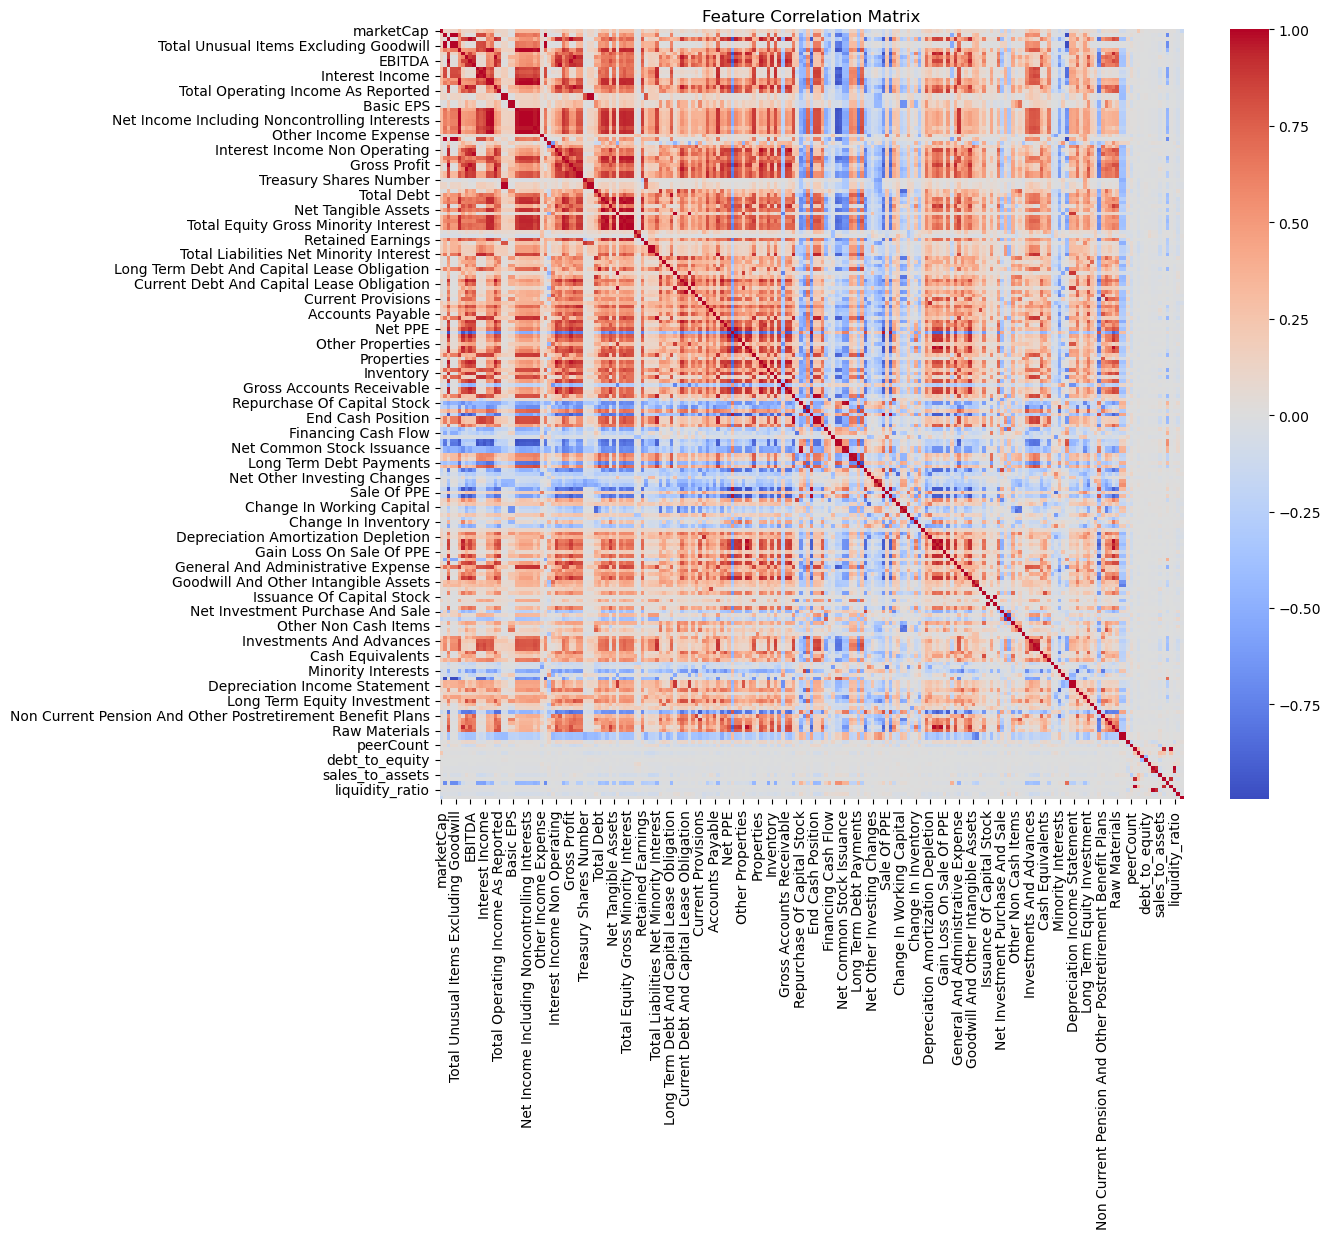

In [43]:
corr_matrix = num_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [44]:
# Convert to Distance Matrix 
corr_matrix = corr_matrix.fillna(0)
distance_matrix_full = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix_full.values, 0) # Ensure diagonal is zero
condensed_distance_matrix = squareform(distance_matrix_full, checks=False)

In [45]:
# Perform Hierarchical Clustering 
Z = linkage(condensed_distance_matrix, method='average') # Using 'average' linkage: uses the average of the distances between all pairs of points, one from each of the two sets of items.

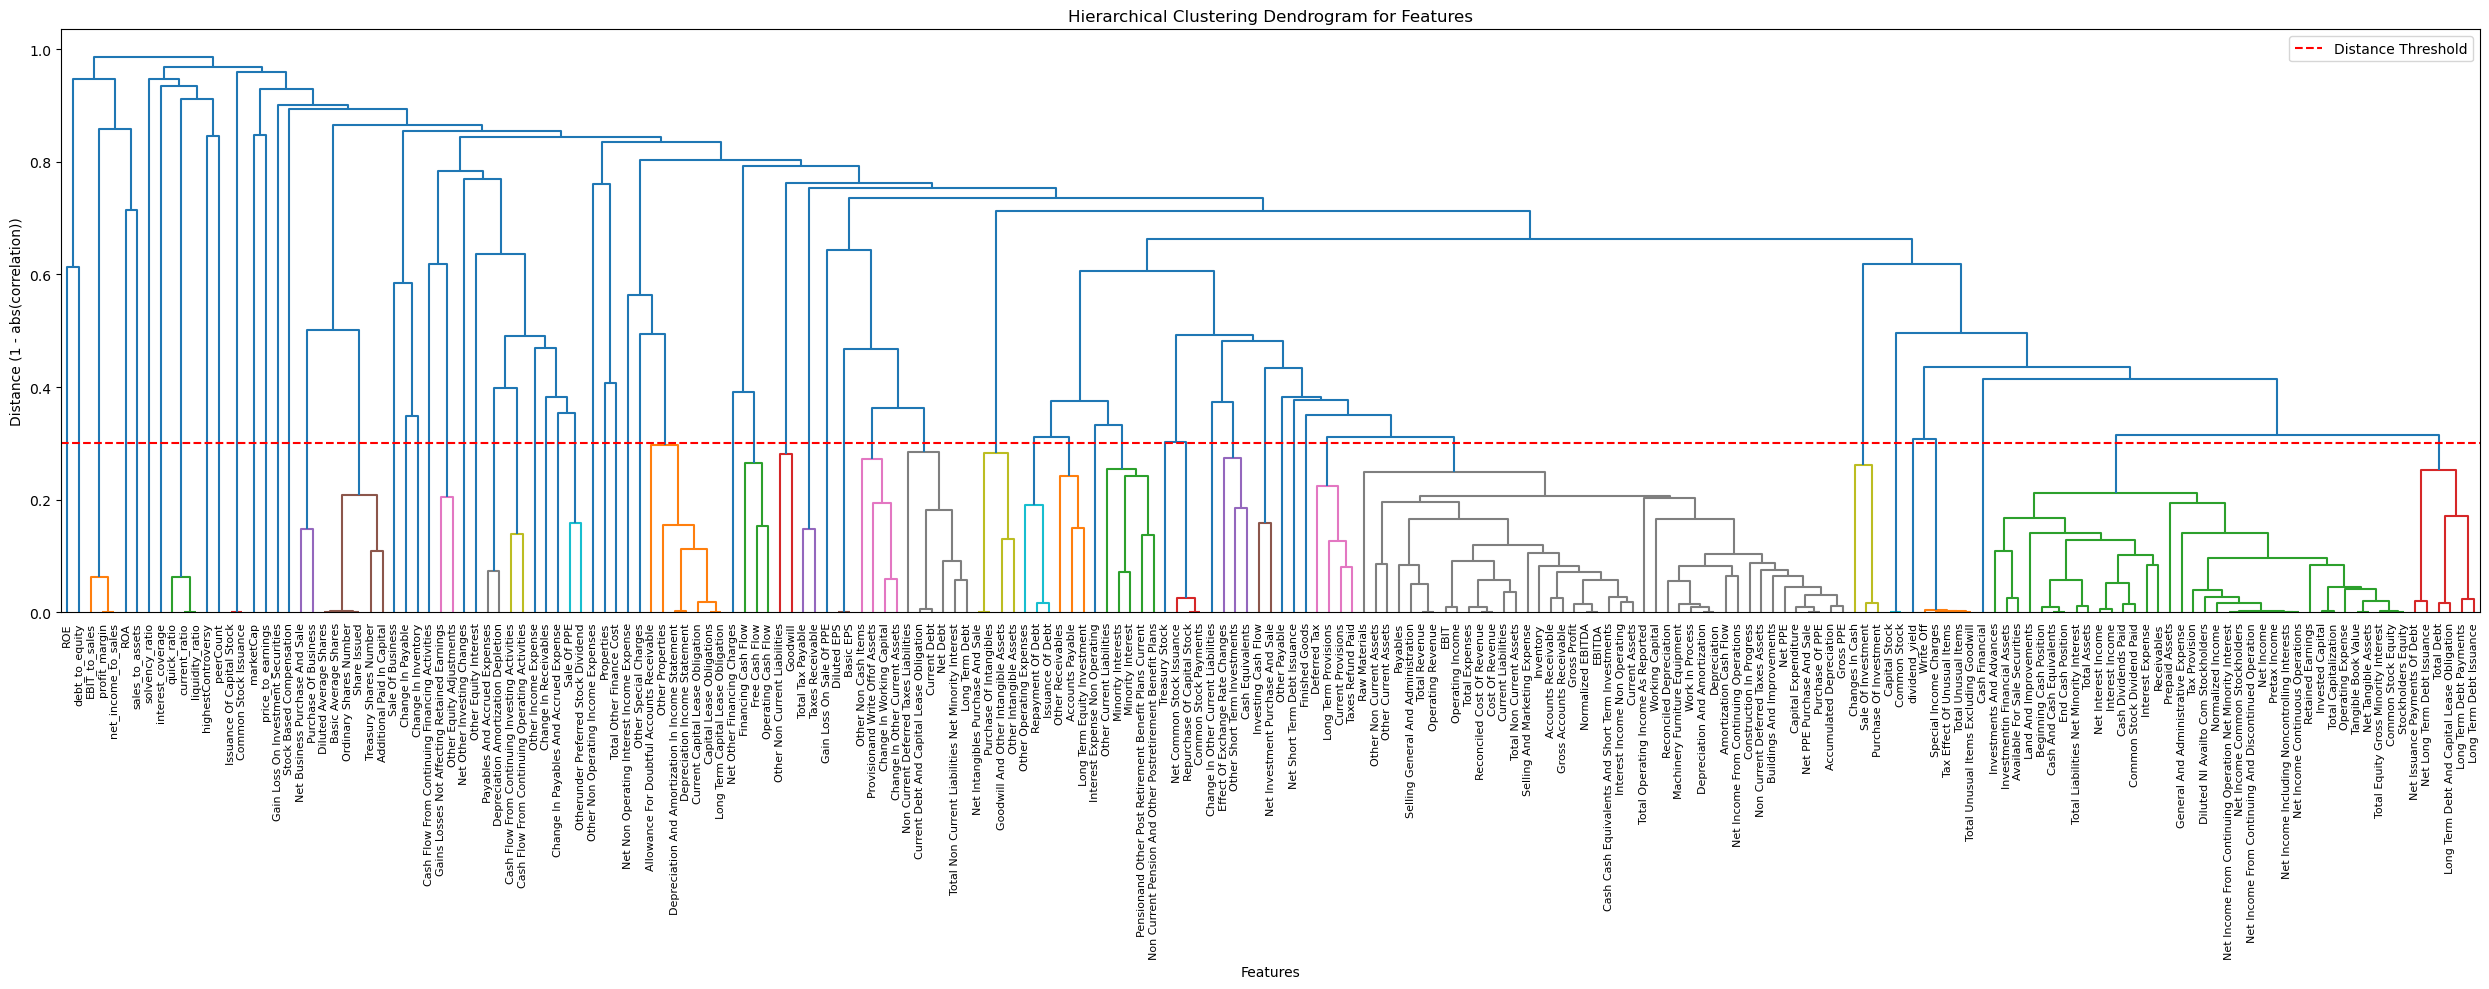

In [46]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram for Features')
plt.xlabel('Features')
plt.ylabel('Distance (1 - abs(correlation))')
dendrogram(
    Z,
    labels=corr_matrix.columns.tolist(),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=0.3 
    # truncate_mode='lastp', p=50 # show only the last 50 merged clusters
)
plt.axhline(y=0.3, color='r', linestyle='--', label='Distance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Form Flat Clusters 
distance_threshold = 0.3 # chosen based on dendrogram
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [48]:
# Create a mapping from cluster ID to feature names
cluster_map = pd.DataFrame({'Feature': corr_matrix.columns, 'ClusterID': clusters})
print(f"Number of clusters found: {cluster_map['ClusterID'].nunique()}")

Number of clusters found: 66


In [49]:
# Select Representative Features

# select the first feature encountered for each cluster
# representatives = cluster_map.drop_duplicates(subset=['ClusterID'], keep='first')['Feature'].tolist()

In [50]:
# select the feature with the highest mean absolute correlation with the target variable
y_aligned = y.loc[num_df.index]
target_correlations = num_df.corrwith(y_aligned).abs() # Calculate correlation and take absolute value
target_correlations = target_correlations.fillna(0) # Fill NaNs if any feature had zero variance
target_correlations.name = 'AbsCorrWithTarget' # Name the series

In [51]:
# add target correlation to the cluster map
cluster_map_with_corr = cluster_map.merge(target_correlations,
                                              left_on='Feature',
                                              right_index=True,
                                              how='left')

In [52]:
# Find the feature with the max absolute target correlation within each cluster
print("Selecting feature with highest absolute target correlation per cluster...")
# Sort by correlation within group to easily get max (idxmax handles ties by taking first)
# Using loc[groupby().idxmax()] is efficient
representatives_df = cluster_map_with_corr.loc[cluster_map_with_corr.groupby('ClusterID')['AbsCorrWithTarget'].idxmax()]
representatives = representatives_df['Feature'].tolist()

Selecting feature with highest absolute target correlation per cluster...


In [53]:
# Display the selected feature and its correlation for each cluster
print("\nRepresentative Features and their Absolute Correlation with Target:")
print(representatives_df[['ClusterID', 'Feature', 'AbsCorrWithTarget']].to_markdown(index=False))


Representative Features and their Absolute Correlation with Target:
|   ClusterID | Feature                                                    |   AbsCorrWithTarget |
|------------:|:-----------------------------------------------------------|--------------------:|
|           1 | ROE                                                        |         0.000443558 |
|           2 | debt_to_equity                                             |         0.0223307   |
|           3 | EBIT_to_sales                                              |         0.0670515   |
|           4 | ROA                                                        |         0.105722    |
|           5 | sales_to_assets                                            |         0.0677329   |
|           6 | current_ratio                                              |         0.0295479   |
|           7 | highestControversy                                         |         0.139429    |
|           8 | peerCount               

In [54]:
print(f"Number of representative features selected: {len(representatives)}")
# Ensure representatives are unique (should be by design, but check)
representatives = list(dict.fromkeys(representatives))
print(f"Final number of unique representative features: {len(representatives)}")
print("Selected Features:", representatives)

Number of representative features selected: 66
Final number of unique representative features: 66
Selected Features: ['ROE', 'debt_to_equity', 'EBIT_to_sales', 'ROA', 'sales_to_assets', 'current_ratio', 'highestControversy', 'peerCount', 'interest_coverage', 'solvency_ratio', 'Issuance Of Capital Stock', 'marketCap', 'price_to_earnings', 'Purchase Of Business', 'Share Issued', 'Change In Payable', 'Change In Inventory', 'Sale Of Business', 'Gains Losses Not Affecting Retained Earnings', 'Cash Flow From Continuing Financing Activities', 'Payables And Accrued Expenses', 'Cash Flow From Continuing Operating Activities', 'Sale Of PPE', 'Change In Payables And Accrued Expense', 'Change In Receivables', 'Other Income Expense', 'Other Equity Interest', 'Net Other Investing Changes', 'Properties', 'Total Other Finance Cost', 'Other Non Operating Income Expenses', 'Other Properties', 'Other Special Charges', 'Net Non Operating Interest Income Expense', 'Free Cash Flow', 'Net Other Financing Cha

In [55]:
# Merge back the target variable and categorical features
final_features = ['symbol', 'date', 'region', 'companySize'] + representatives + list(set(financial_ratios.keys()) - set(representatives)) + ['totalEsg']
df_filtered = df_latest[final_features]

In [56]:
df_filtered.sort_index().head(10)

,symbol,date,region,companySize,ROE,debt_to_equity,EBIT_to_sales,ROA,sales_to_assets,current_ratio,...,Prepaid Assets,Total Debt,Cash Financial,Stock Based Compensation,Gain Loss On Investment Securities,quick_ratio,profit_margin,liquidity_ratio,net_income_to_sales,totalEsg
0,FAST,2024-12-31,north_america,Mid-Cap,0.318171,0.134226,0.200822,0.244913,1.606215,4.674574,...,1.880000e+07,4.854000e+08,8.401500e+08,8.000000e+06,-1.360000e+07,2.280454,0.152478,4.674574,0.152478,25.04
9,BXSL,2024-12-31,north_america,Small-Cap,0.114226,1.161206,0.697423,0.051521,0.054279,0.238717,...,7.895200e+07,7.056091e+09,1.973590e+08,3.475000e+07,-3.125317e+09,-0.309630,0.949174,0.238717,0.949174,29.32
14,NED.JO,2024-12-31,sub_saharan_africa,Mid-Cap,0.134605,0.415764,0.109108,0.012915,0.047586,1.883886,...,2.436830e+08,5.242200e+10,5.806000e+09,7.470000e+08,-5.520000e+08,1.469634,0.271410,1.883886,0.271410,14.43
19,SCBGF,2024-12-31,north_america,Small-Cap,0.062099,0.788959,0.121556,0.025295,0.432880,0.582181,...,7.895200e+07,2.471100e+09,5.916000e+08,3.200000e+06,-1.250000e+07,0.405533,0.058435,0.582181,0.058435,10.55
24,SMAWF,2024-09-30,north_america,Large-Cap,0.161926,0.852181,0.171368,0.056159,0.513693,1.397149,...,2.720000e+08,4.791900e+10,5.717000e+09,3.480000e+08,-9.180000e+08,1.154601,0.109324,1.397149,0.109324,25.84
28,APP.MX,2024-12-31,latin_america_n_caribbean,Small-Cap,1.447085,3.263302,0.402244,0.269161,0.802358,2.186526,...,1.500400e+08,3.556405e+09,2.227500e+09,3.693670e+08,-5.680000e+06,0.462603,0.335462,2.186526,0.335462,19.25
33,7911.T,2024-03-31,east_asia_n_pacific,Small-Cap,0.052510,0.133002,0.078167,0.030579,0.689818,2.198792,...,7.426700e+10,2.084550e+11,2.170783e+11,1.530000e+08,-7.208300e+10,1.926292,0.044329,2.198792,0.044329,7.78
37,BAJAJFINSV.NS,2024-03-31,south_asia,Large-Cap,0.135057,2.204576,0.398223,0.015147,0.185675,1.389557,...,2.474000e+08,2.287817e+12,7.643050e+09,3.925200e+09,-3.395600e+10,1.083863,0.081576,1.389557,0.081576,26.53
41,7267.T,2024-03-31,east_asia_n_pacific,Mid-Cap,0.087200,0.309575,0.083314,0.037186,0.686125,1.426392,...,1.882578e+11,4.026291e+12,3.381610e+12,1.624000e+09,-6.770000e+09,1.132889,0.054197,1.426392,0.054197,26.72
46,DTE.PR,2024-12-31,europe_n_central_asia,Large-Cap,0.177089,1.471472,0.258125,0.036759,0.377495,1.056250,...,5.320000e+08,1.451460e+11,1.157100e+10,2.385000e+09,3.319000e+09,0.986584,0.097376,1.056250,0.097376,18.34


### Categorical Encoding

In [61]:
categorical_cols = ['region', 'companySize']
X_cat = df_filtered[categorical_cols]

In [63]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat)

In [ ]:
X_cat_encoded_df = pd.DataFrame(X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
X_cat_encoded_df = X_cat_encoded_df.set_index(df_filtered.index)

,region_east_asia_n_pacific,region_europe_n_central_asia,region_latin_america_n_caribbean,region_middle_east_n_africa,region_north_america,region_south_asia,region_sub_saharan_africa,companySize_Large-Cap,companySize_Mid-Cap,companySize_Small-Cap
4570,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3894,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1521,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4618,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
df_encoded = pd.concat([df_filtered.drop(columns=categorical_cols), X_cat_encoded_df], axis=1)
df_encoded.sort_index().head(10)

,symbol,date,ROE,debt_to_equity,EBIT_to_sales,ROA,sales_to_assets,current_ratio,highestControversy,peerCount,...,region_east_asia_n_pacific,region_europe_n_central_asia,region_latin_america_n_caribbean,region_middle_east_n_africa,region_north_america,region_south_asia,region_sub_saharan_africa,companySize_Large-Cap,companySize_Mid-Cap,companySize_Small-Cap
0,FAST,2024-12-31,0.318171,0.134226,0.200822,0.244913,1.606215,4.674574,2.0,94,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,BXSL,2024-12-31,0.114226,1.161206,0.697423,0.051521,0.054279,0.238717,0.0,356,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14,NED.JO,2024-12-31,0.134605,0.415764,0.109108,0.012915,0.047586,1.883886,2.0,454,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19,SCBGF,2024-12-31,0.062099,0.788959,0.121556,0.025295,0.432880,0.582181,1.0,42,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
24,SMAWF,2024-09-30,0.161926,0.852181,0.171368,0.056159,0.513693,1.397149,2.0,62,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
28,APP.MX,2024-12-31,1.447085,3.263302,0.402244,0.269161,0.802358,2.186526,2.0,597,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33,7911.T,2024-03-31,0.052510,0.133002,0.078167,0.030579,0.689818,2.198792,1.0,210,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37,BAJAJFINSV.NS,2024-03-31,0.135057,2.204576,0.398223,0.015147,0.185675,1.389557,1.0,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
41,7267.T,2024-03-31,0.087200,0.309575,0.083314,0.037186,0.686125,1.426392,4.0,48,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46,DTE.PR,2024-12-31,0.177089,1.471472,0.258125,0.036759,0.377495,1.056250,2.0,100,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Feature Scaling